# High OSK vs iPSC MoDISco

Compare high OSK vs iPSC Modisco.

In [1]:
import modisco
import h5py
import deepdish
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
import matplotlib

# for pdf text saving 
matplotlib.rcParams['pdf.fonttype'] = 42

from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm
import pyBigWig
import pyfaidx

In [6]:
!pip freeze | grep modisco

modisco==0.5.14.0


In [7]:
import os

In [8]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [9]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

## Load Data

In [10]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
MODISCO_CROP_WIDTH = 500

In [11]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [12]:
def get_regions(regions_file, crop_width):
    with open(regions_file) as f:
        scored_regions = [x.strip().split('\t') for x in f]

    # importance scores are computed centered at summit (2nd col + 10th col)
    scored_regions = [(x[0], int(x[9])+int(x[1])-crop_width//2, int(x[9])+int(x[1])+crop_width//2) for x in scored_regions]
    
    return scored_regions

In [13]:
def fetch_data(modisco_hdf5, pattern_name, pattern_start, pattern_end,
               imp_scores, regions, insertions_bw_file, 
               pred_w_bias_bw_file, pred_wo_bias_bw_file, 
               modisco_crop_width, genome, rc_everything=False, expand_bw=100):
    """
    this function basically goes through the seqlets of a given pattern (pattern_name)
    it pulls out raw shap scores for each seqlet, its coordinates, whether it's RC-ed,
    its subcluster indices
    also pulls out raw insertions for each seqlet (out expand_bw on both sides), and same
    for predicted profiles w/ and w/o bias 
    
    returned seqlets all have the same orientation!
    pattern_start -> start of pattern within seqlet ([0,seqlen_len)]
    pattern_end-> start of pattern within seqlen ((pattern_start,seqlen_len)]
    """
    
    assert(len(regions)==imp_scores['shap']['seq'].shape[0])
    
    # region sliced out and used for modisco
    imp_width = imp_scores['shap']['seq'].shape[-1]
    imp_crop_start = imp_width//2 - modisco_crop_width//2
    imp_crop_end = imp_width//2 + modisco_crop_width//2
    
    pattern = modisco_hdf5['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][pattern_name]
    
    seqlet_len = pattern["sequence"]["fwd"].shape[0]
    
    subcluster_idxs = np.array(list(pattern["subclusters"]))
    
    insertions_bw = pyBigWig.open(insertions_bw_file)
    pred_w_bias_bw = pyBigWig.open(pred_w_bias_bw_file)
    pred_wo_bias_bw = pyBigWig.open(pred_wo_bias_bw_file)
    
    seqlet_coords = []
    seqlet_is_rc = []
    seqlet_shaps = []
    seqlet_one_hots = []
    seqlet_pred_wo_bias = []
    seqlet_pred_w_bias = []
    seqlet_insertions = []
    
    # fetch info from the bigwigs where the seqlets are present
    for i in tqdm.trange(len(pattern['seqlets_and_alnmts']['seqlets'])):
        x = pattern['seqlets_and_alnmts']['seqlets'][i]
        
        # index into regions/imp_scores, i.e. which entry in regions does each seqlet come from
        idx = int(x.decode('utf8').split(',')[0].split(':')[1])
        start = int(x.decode('utf8').split(',')[1].split(':')[1])
        rc = eval(x.decode('utf8').split(',')[3].split(':')[1])

        reg = regions[idx]

        cur_proj_shap_scores = imp_scores['projected_shap']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()
        cur_one_hot = imp_scores['raw']['seq'][idx][:, imp_crop_start:imp_crop_end].transpose()

        seqlet_is_rc.append(rc)
        
        if rc:
            seqlet_shaps.append(revcomp(cur_proj_shap_scores[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))
            seqlet_one_hots.append(revcomp(cur_one_hot[start+(seqlet_len-pattern_end):start+(seqlet_len-pattern_start)]))

            start_coord = reg[1]+start+(seqlet_len-pattern_end)
            end_coord = reg[1]+start+(seqlet_len-pattern_start)
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw
            
            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded))[::-1])

        else:
            seqlet_shaps.append(cur_proj_shap_scores[start+pattern_start:start+pattern_end])
            seqlet_one_hots.append(cur_one_hot[start+pattern_start:start+pattern_end])
            
            start_coord = reg[1]+start+pattern_start
            end_coord = reg[1]+start+pattern_end
            seqlet_coords.append([reg[0], start_coord, end_coord])
            
            start_coord_expanded = start_coord - expand_bw
            end_coord_expanded = end_coord + expand_bw

            seqlet_pred_wo_bias.append(np.nan_to_num(pred_wo_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
            seqlet_pred_w_bias.append(np.nan_to_num(pred_w_bias_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))    
            seqlet_insertions.append(np.nan_to_num(insertions_bw.values(reg[0], start_coord_expanded, end_coord_expanded)))
    
    insertions_bw.close()
    pred_w_bias_bw.close()
    pred_wo_bias_bw.close()
    
    # RC-ing all instances
    seqlet_shaps = np.array(seqlet_shaps) #[:,::-1,::-1]
    seqlet_one_hots = np.array(seqlet_one_hots)  # [:,::-1,::-1]
    seqlet_pred_wo_bias = np.array(seqlet_pred_wo_bias)
    seqlet_pred_w_bias = np.array(seqlet_pred_w_bias)
    seqlet_insertions = np.array(seqlet_insertions)
    
    if rc_everything:
        seqlet_shaps = seqlet_shaps[:, ::-1, ::-1]
        seqlet_one_hots = seqlet_one_hots[:, ::-1, ::-1]
        seqlet_pred_wo_bias = seqlet_pred_wo_bias[:, ::-1]
        seqlet_pred_w_bias = seqlet_pred_w_bias[:, ::-1]
        seqlet_insertions = seqlet_insertions[:, ::-1]
    
    return seqlet_coords, seqlet_is_rc, subcluster_idxs, seqlet_shaps, seqlet_one_hots, seqlet_insertions, seqlet_pred_w_bias, seqlet_pred_wo_bias

### High OSK MoDISco

In [14]:
HIGH_OSK_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/modisco/modisco_results_allChroms_counts.hdf5"
HIGH_OSK_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/counts_scores.h5"
HIGH_OSK_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/interpret/interpreted_regions.bed"

In [15]:
high_OSK_modisco = h5py.File(HIGH_OSK_MODISCO_PATH, 'r')

In [16]:
high_OSK_imp_scores = deepdish.io.load(HIGH_OSK_HDF5_PATH)

In [17]:
high_OSK_regions = get_regions(HIGH_OSK_REG_PATH, MODISCO_CROP_WIDTH)

In [18]:
# patterns

# OS: pattern_0 : 8 - 24
# KLF: pattern_1 : 6 - 16

In [19]:
high_OSK_coords, high_OSK_is_rc, \
high_OSK_subcluster_idxs, \
high_OSK_shaps, high_OSK_one_hots, \
high_OSK_insertions, high_OSK_pred_w_bias,\
high_OSK_pred_wo_bias = \
        fetch_data(high_OSK_modisco, "pattern_0", 8, 24,
                   high_OSK_imp_scores, high_OSK_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx11.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx11/predict/cluster_idx11_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=True, expand_bw=100)

100%|██████████| 9502/9502 [00:09<00:00, 978.15it/s] 


In [20]:
high_OSK_one_hots.shape

(9502, 16, 4)

In [21]:
Counter(high_OSK_subcluster_idxs).most_common()

[(0, 2115),
 (1, 1648),
 (2, 1638),
 (3, 1519),
 (4, 1386),
 (5, 506),
 (6, 215),
 (7, 210),
 (8, 146),
 (9, 60),
 (10, 33),
 (11, 15),
 (12, 11)]

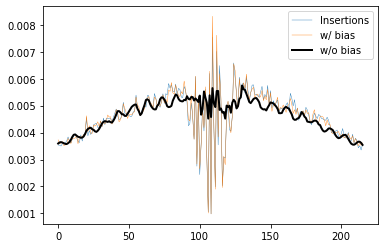

In [22]:
plt.plot(np.array([x/sum(x) for x in high_OSK_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in high_OSK_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in high_OSK_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

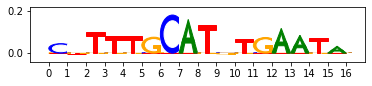

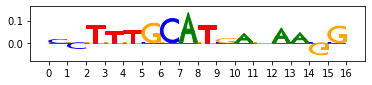

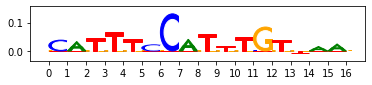

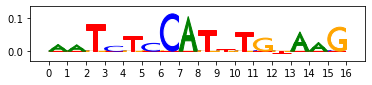

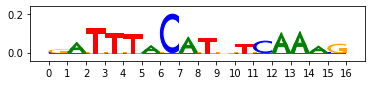

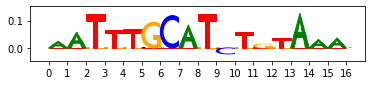

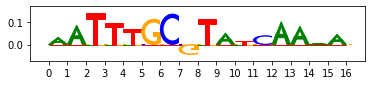

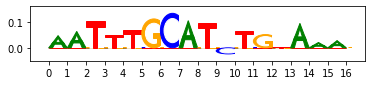

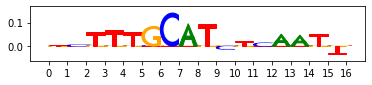

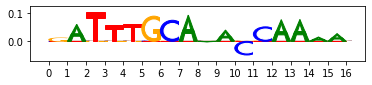

In [23]:
for i in range(10): 
    viz_sequence.plot_weights(high_OSK_shaps[i], figsize=(6,1))

### iPSC data

In [24]:
IPSC_MODISCO_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/modisco/modisco_results_allChroms_counts.hdf5"
IPSC_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/interpret/counts_scores.h5"
IPSC_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/interpret/interpreted_regions.bed"

In [25]:
ipsc_modisco = h5py.File(IPSC_MODISCO_PATH, 'r')

In [26]:
ipsc_imp_scores = deepdish.io.load(IPSC_HDF5_PATH)

In [27]:
ipsc_regions = get_regions(IPSC_REG_PATH, MODISCO_CROP_WIDTH)

In [86]:
# patterns

# OS: pattern_1 : 7 - 23

In [28]:
ipsc_coords, ipsc_is_rc, \
ipsc_subcluster_idxs, \
ipsc_shaps, ipsc_one_hots, \
ipsc_insertions, ipsc_pred_w_bias,\
ipsc_pred_wo_bias = \
        fetch_data(ipsc_modisco, "pattern_1", 7, 23,
                   ipsc_imp_scores, ipsc_regions, 
                   "/users/surag/oak/projects/scATAC-reprog/clusters/20210714_n64913/bigwigs/cluster_idx8.bw", 
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/predict/cluster_idx8_w_bias.bw",
                   "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx8/predict/cluster_idx8_wo_bias.bw",
                   MODISCO_CROP_WIDTH, hg38, rc_everything=False, expand_bw=100)

100%|██████████| 3311/3311 [00:03<00:00, 963.80it/s]


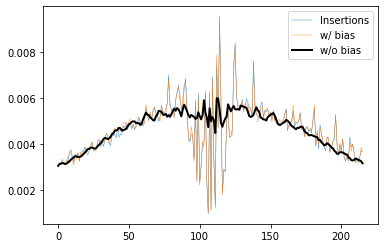

In [29]:
plt.plot(np.array([x/sum(x) for x in ipsc_insertions if sum(x)>0]).mean(0), label="Insertions", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in ipsc_pred_w_bias]).mean(0), label="w/ bias", linewidth=0.4)
plt.plot(np.array([x/sum(x) for x in ipsc_pred_wo_bias]).mean(0), label="w/o bias", linewidth=2, c='k')
plt.legend()

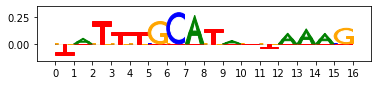

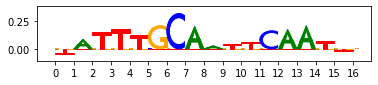

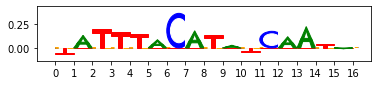

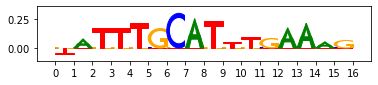

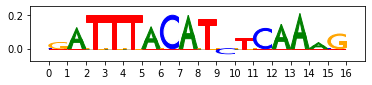

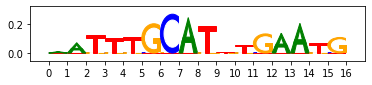

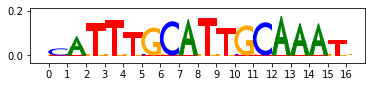

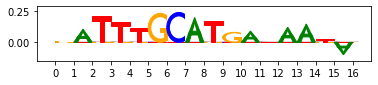

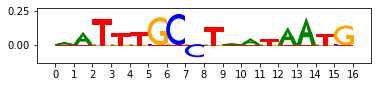

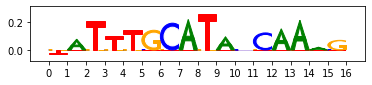

In [30]:
for i in range(10): 
    viz_sequence.plot_weights(ipsc_shaps[i], figsize=(6,1))

## Computing log-odds scores and comparing iPSC vs high OSK motifs

In [163]:
IPSC_OCTONLY_SUBCLUSTER = 2

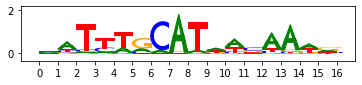

In [86]:
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots.mean(0), background=[0.25]*4), 
                          figsize=(6,1))

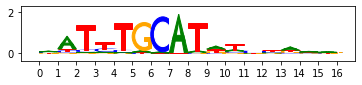

In [164]:
# cluster which is mostly OCT
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots[ipsc_subcluster_idxs==IPSC_OCTONLY_SUBCLUSTER].mean(0), background=[0.25]*4), figsize=(6,1))

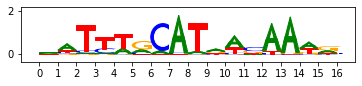

In [165]:
# excluding cluster which is mostly OCT
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_one_hots[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER].mean(0), background=[0.25]*4), 
                          figsize=(6,1))

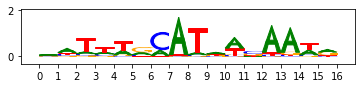

In [166]:
viz_sequence.plot_weights(viz_sequence.ic_scale(high_OSK_one_hots.mean(0), background=[0.25]*4),
                          figsize=(6,1))

In [167]:
from random import sample, randint, shuffle

In [168]:
# exclude OCT only cluster for iPSC
ipsc_one_hots_wo_OCT_only = ipsc_one_hots[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER]
ipsc_pwm = ipsc_one_hots_wo_OCT_only.sum(0)
ipsc_pwm = ipsc_pwm/np.sum(ipsc_pwm, axis=1, keepdims=True)
ipsc_logodds_mat = np.log(ipsc_pwm/0.25)

high_OSK_pwm = high_OSK_one_hots.sum(0)
high_OSK_pwm = high_OSK_pwm/np.sum(high_OSK_pwm, axis=1, keepdims=True)
high_OSK_logodds_mat = np.log(high_OSK_pwm/0.25)

# equal weight for both
mixed_pwm = (high_OSK_one_hots.sum(0)/high_OSK_one_hots.shape[0]) + (ipsc_one_hots_wo_OCT_only.sum(0)/ipsc_one_hots_wo_OCT_only.shape[0])
mixed_pwm = mixed_pwm/np.sum(mixed_pwm, axis=1, keepdims=True)
mixed_logodds_mat = np.log(mixed_pwm/0.25)

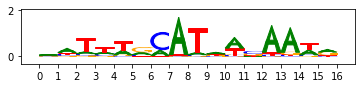

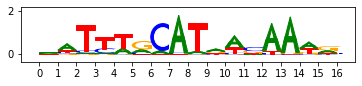

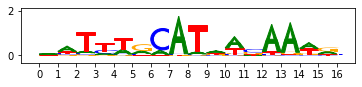

In [169]:
viz_sequence.plot_weights(viz_sequence.ic_scale(high_OSK_pwm, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(ipsc_pwm, background=[0.25]*4), figsize=(6,1))
viz_sequence.plot_weights(viz_sequence.ic_scale(mixed_pwm, background=[0.25]*4), figsize=(6,1))

In [170]:
print(np.median(np.sum(high_OSK_one_hots*high_OSK_logodds_mat, axis=(1,2))))
print(np.median(np.sum(high_OSK_one_hots*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(high_OSK_one_hots*mixed_logodds_mat, axis=(1,2))))

8.035137908761474
7.518118781101658
7.958049325152175


In [171]:
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*high_OSK_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots_wo_OCT_only*mixed_logodds_mat, axis=(1,2))))

9.550998546600264
10.027481061616035
9.925198571187043


In [172]:
import seaborn as sns

In [173]:
THRESH = 5

to_plot_ipsc = np.sum(ipsc_one_hots_wo_OCT_only*mixed_logodds_mat, axis=(1,2))
to_plot_ipsc = to_plot_ipsc[to_plot_ipsc>THRESH]

to_plot_high_OSK = np.sum(high_OSK_one_hots*mixed_logodds_mat, axis=(1,2))
to_plot_high_OSK = to_plot_high_OSK[to_plot_high_OSK>THRESH]

In [174]:
np.median(to_plot_ipsc), np.median(to_plot_high_OSK)

(9.956307247986341, 8.276358518169829)

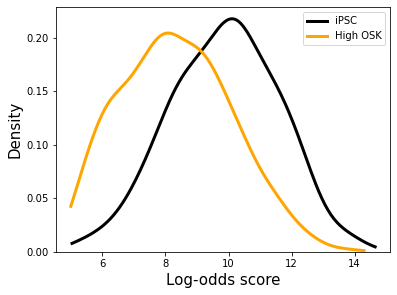

In [176]:
sns.kdeplot(to_plot_ipsc, label='iPSC', cut=0, c='k', linewidth=3, bw_adjust=1.5)
sns.kdeplot(to_plot_high_OSK, label='High OSK', cut=0, c='orange', linewidth=3, bw_adjust=1.5)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend()
plt.savefig("./subfigs/iPSC_vs_high_OSK_OCTSOX_scores.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

Text(0, 0.5, 'Log-odds')

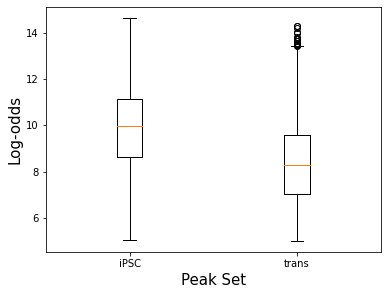

In [177]:
plt.boxplot([to_plot_ipsc,to_plot_high_OSK],
            labels=["iPSC","trans"])
plt.xlabel("Peak Set", fontsize=15)
plt.ylabel("Log-odds", fontsize=15)
# plt.show()
# plt.savefig("tmp.pdf")

In [178]:
import scipy
print(scipy.stats.mannwhitneyu(to_plot_high_OSK, to_plot_ipsc)[1])

1.8442873017745612e-285


## Matrix of instances

In [179]:
# same as R
cmap = sns.color_palette(['#109648', '#255C99', '#F7B32B', '#D62839']) 
cmap

[(0.06274509803921569, 0.5882352941176471, 0.2823529411764706),
 (0.1450980392156863, 0.3607843137254902, 0.6),
 (0.9686274509803922, 0.7019607843137254, 0.16862745098039217),
 (0.8392156862745098, 0.1568627450980392, 0.2235294117647059)]

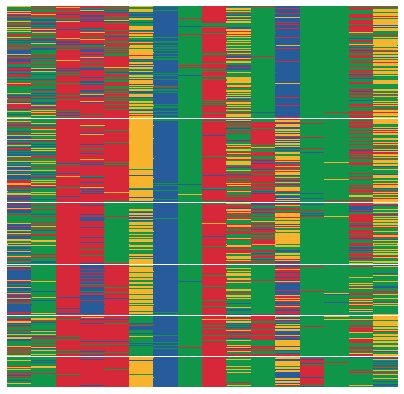

In [230]:
f, ax = plt.subplots(figsize=(7,7))

ipsc_wo_OCT_only_subscluster_idx = ipsc_subcluster_idxs[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER]

cur = sns.heatmap(np.argmax(ipsc_one_hots_wo_OCT_only[np.argsort(ipsc_wo_OCT_only_subscluster_idx)], -1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax,
                 cbar=0)

for i in np.cumsum([x[1] for x in Counter(ipsc_wo_OCT_only_subscluster_idx).most_common()]) + 1:
    ax.axhline(i, color='white', lw=1)

cur.set(xticklabels=range(1,17))
cur.set(yticklabels=[])
cur.set(xticklabels=[])
cur.set(xticks=[])
cur.set(yticks=[])

plt.savefig("./subfigs/iPSC.wo.OCT.only.OCTSOX.seqlets.heatmap.pdf")
# plt.show()

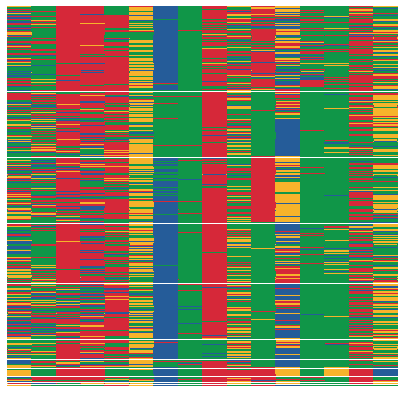

In [229]:
f, ax = plt.subplots(figsize=(7,7))

cur = sns.heatmap(np.argmax(high_OSK_one_hots[np.argsort(high_OSK_subcluster_idxs)], -1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax,
                 cbar=0)

for i in np.cumsum([x[1] for x in Counter(high_OSK_subcluster_idxs).most_common()]) + 1:
    ax.axhline(i, color='white', lw=1)
    
cur.set(xticklabels=range(1,17))
cur.set(yticklabels=[])
cur.set(xticklabels=[])
cur.set(xticks=[])
cur.set(yticks=[])

plt.savefig("./subfigs/high.OSK.OCTSOX.seqlets.heatmap.pdf")
# plt.show()

### Subscluster specific PWMs, aggregate CWM/PWM

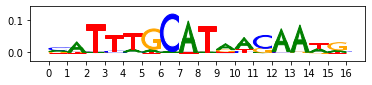

In [184]:
viz_sequence.plot_weights(ipsc_shaps.mean(0), figsize=(6,1))

In [195]:
# check if stored CWM is same as average of extracted shap values
np.all(np.equal(ipsc_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_1"]["task0_contrib_scores"]["fwd"][7:23],
                ipsc_shaps.mean(0)))

True

Need to recompute aggregate PWM/CWM for high OSK since removed one subcluster (OCT only).

**High OSK**

In [276]:
pwm = revcomp(high_OSK_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_0"]["sequence"]["fwd"][8:24])
cwm = revcomp(high_OSK_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_0"]["task0_contrib_scores"]["fwd"][8:24])

In [277]:
pwm[6]

array([0.24836876, 0.72984635, 0.00568301, 0.01610187])

True

In [255]:
np.all(np.equal(cwm, high_OSK_shaps.mean(0)))

True

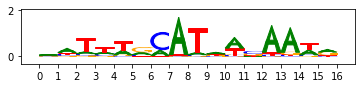

In [238]:
viz_sequence.plot_weights(viz_sequence.ic_scale(pwm, background=[0.25]*4), figsize=(6,1))

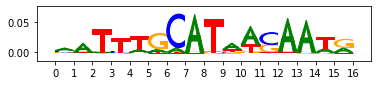

In [239]:
viz_sequence.plot_weights(cwm,figsize=(6,1))

In [248]:
np.savetxt("./OS_motif_intermediate/high_OSK/agg_PWM.txt", pwm)
np.savetxt("./OS_motif_intermediate/high_OSK/agg_CWM.txt", cwm)

In [262]:
for x in set(high_OSK_subcluster_idxs):
    # don't have to revcomp, high_OSK_one_hots is already rc-ed
    mat = high_OSK_one_hots[high_OSK_subcluster_idxs==x].mean(0)
    np.savetxt("./OS_motif_intermediate/high_OSK/subcluster_{}_pwm.txt".format(x), mat)
#     viz_sequence.plot_weights(viz_sequence.ic_scale(mat, background=[0.25]*4), figsize=(6,1))

In [253]:
with open("./OS_motif_intermediate/high_OSK/subcluster_counts.txt", 'w') as f:
    for x in sorted(set(high_OSK_subcluster_idxs)):
        f.write("{}\t{}\n".format(x, sum(high_OSK_subcluster_idxs==x)))

**iPSC**

In [274]:
pwm = ipsc_one_hots[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER].mean(0)
cwm = ipsc_shaps[ipsc_subcluster_idxs!=IPSC_OCTONLY_SUBCLUSTER].mean(0)

In [275]:
pwm[6]

array([0.10841602, 0.88092613, 0.00257258, 0.00808526])

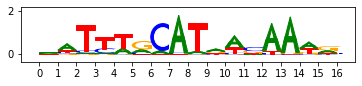

In [257]:
viz_sequence.plot_weights(viz_sequence.ic_scale(pwm, background=[0.25]*4), figsize=(6,1))

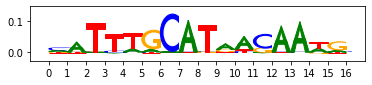

In [258]:
viz_sequence.plot_weights(cwm,figsize=(6,1))

In [259]:
np.savetxt("./OS_motif_intermediate/iPSC/agg_PWM.txt", pwm)
np.savetxt("./OS_motif_intermediate/iPSC/agg_CWM.txt", cwm)

In [268]:
i = 0
for x in sorted(set(ipsc_subcluster_idxs)):
    if x != IPSC_OCTONLY_SUBCLUSTER:
        mat = ipsc_one_hots[ipsc_subcluster_idxs==x].mean(0)
        np.savetxt("./OS_motif_intermediate/iPSC/subcluster_{}_pwm.txt".format(i), mat)
        i+=1
#         viz_sequence.plot_weights(viz_sequence.ic_scale(mat, background=[0.25]*4), figsize=(6,1))

In [269]:
with open("./OS_motif_intermediate/iPSC/subcluster_counts.txt", 'w') as f:
    i=0
    for x in sorted(set(ipsc_subcluster_idxs)):
        if x!=IPSC_OCTONLY_SUBCLUSTER:
            f.write("{}\t{}\n".format(i, sum(ipsc_subcluster_idxs==x)))
            i+=1

In [273]:
np.sum(ipsc_subcluster_idxs==6)

220

In [ ]:
for i in range(len()-1):

In [211]:
len(ipsc_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']['pattern_1']['seqlets_and_alnmts']['seqlets'])

3311

In [224]:
lol = [len(ipsc_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_{}".format(x)]['seqlets_and_alnmts']['seqlets']) for x in \
 range(len(ipsc_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'].keys())-1)]
lol[1]/sum(lol)

0.12002465018487639

In [221]:
lol = [len(high_OSK_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_{}".format(x)]['seqlets_and_alnmts']['seqlets']) for x in \
 range(len(high_OSK_modisco['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'].keys())-1)]
lol[0]/sum(lol)

0.3780385916053312

### UMAP

In [56]:
import umap

In [57]:
high_OSK_one_hots.shape

(9502, 16, 4)

In [58]:
ipsc_one_hots.shape

(3311, 16, 4)

In [59]:
np.random.permutation(5)

array([4, 1, 0, 2, 3])

In [60]:
# remove cluster of OCT only
ipsc_one_hots_oct_only = ipsc_one_hots[ipsc_subcluster_idxs!=2]

In [61]:
ipsc_one_hots_oct_only.shape

(2721, 16, 4)

In [67]:
# subsample equal number of transient
subsamp_high_osk_one_hots = high_OSK_one_hots[np.random.permutation(high_OSK_one_hots.shape[0])[:ipsc_one_hots_oct_only.shape[0]]]
subsamp_high_osk_one_hots.shape

(2721, 16, 4)

In [68]:
umap_reducer = umap.UMAP(metric='hamming')

In [71]:
to_emb = np.vstack([subsamp_high_osk_one_hots.reshape((-1, 64)),
               ipsc_one_hots_oct_only.reshape((-1, 64))])
emb = umap_reducer.fit_transform(to_emb)

/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [72]:
emb.shape

(5442, 2)

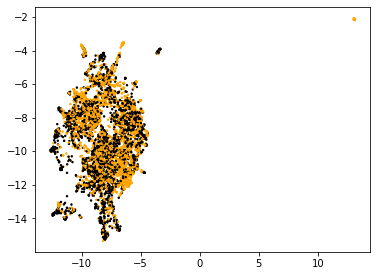

In [81]:
shuf_order = np.random.permutation(emb.shape[0])

plt.rcParams["figure.figsize"] = (6,4.5)
plt.scatter(emb[:,0][shuf_order], emb[:,1][shuf_order], 
            s=2,
           c=np.array(['orange']*subsamp_high_osk_one_hots.shape[0] + 
                      ['k']*ipsc_one_hots_oct_only.shape[0])[shuf_order])

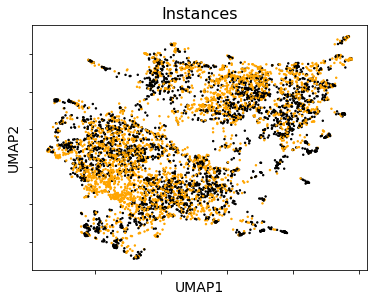

In [219]:
# this is a placeholder plot, make final in R/ggplot
shuf_order = np.random.permutation(emb.shape[0])

plt.rcParams["figure.figsize"] = (6,4.5)
plt.scatter(emb[:,0][shuf_order], emb[:,1][shuf_order], 
            s=2,
           c=np.array(['orange']*subsamp_transient_one_hots.shape[0] + 
                      ['k']*ipsc_one_hots_oct_only.shape[0])[shuf_order])
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
# plt.xticks([])
# plt.yticks([])
plt.title("Instances", fontsize=16)
plt.xlabel("UMAP1", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
# plt.savefig("tmp.pdf")

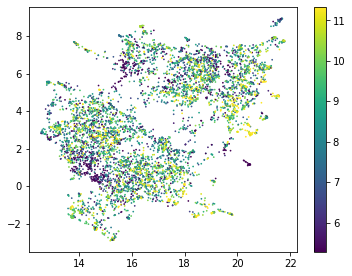

In [225]:
cur_logodds = np.sum(to_emb*mixed_logodds_mat.reshape((-1,60)), axis=-1)

plt.scatter(emb[:,0], emb[:,1], 
            s=0.5,
           c=cur_logodds,
           cmap='viridis',
           vmin=np.quantile(cur_logodds,0.1),
           vmax=np.quantile(cur_logodds,0.9))
plt.colorbar()

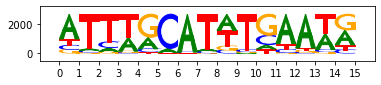

In [223]:
viz_sequence.plot_weights(to_emb.reshape((-1,15,4))[(4*emb[:,0]+3*emb[:,1])>80].sum(0), figsize=(6,1))
# viz_sequence.plot_weights(ipsc_pwm, figsize=(6,1))
# viz_sequence.plot_weights(mixed_pwm, figsize=(6,1))

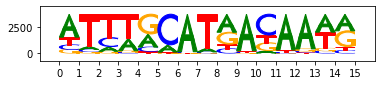

In [224]:
viz_sequence.plot_weights(to_emb.reshape((-1,15,4))[(4*emb[:,0]+3*emb[:,1])<80].sum(0), figsize=(6,1))
# viz_sequence.plot_weights(ipsc_pwm, figsize=(6,1))
# viz_sequence.plot_weights(mixed_pwm, figsize=(6,1))

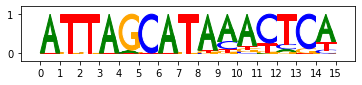

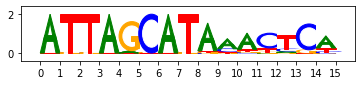

In [228]:
cur_mot = to_emb.reshape((-1,15,4))[(emb[:,0]< 22)&(emb[:,0]>20)&(emb[:,1]> 0)&(emb[:,1]< 2)].sum(0)
cur_mot /= np.sum(cur_mot, axis=1, keepdims=True)

viz_sequence.plot_weights(cur_mot, 
                          figsize=(6,1))

viz_sequence.plot_weights(viz_sequence.ic_scale(cur_mot, background=[0.25]*4),  
                          figsize=(6,1))